Ref principal: https://github.com/eduonix/nlptextclassification/blob/master/NLP%20for%20Text%20Classification%20(Jupyter%20Notebook).ipynb

### Imports

In [1]:
import re
import nltk
import ftfy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

### Carregar dataset

In [2]:
df = pd.read_excel('datasets/Chamados.xlsx')
df.head()

,Classificação,Assunto,Descricao
0,Inc - Con,PROBLEMA DE CONECTIVIDADE,PROBLEMA DE CONECTIVIDADE
1,Inc - Con,PC SEM INTERNET,raquel do bag de dr renato informou que está c...
2,Inc - Con,PC SEM INTERNET,"vanessa , gab dr carlos barros informou proble..."
3,Inc - Con,COMPUTADOR SEM ACESSO A INTERNET,Usuário informa que o computador está sem aces...
4,Inc - Con,COMPUTADOR NÃO ESTÁ LOGANDO,COMPUTADOR NÃO ESTÁ LOGANDO.


### Análise inicial

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 3 columns):
Classificação    2788 non-null object
Assunto          3195 non-null object
Descricao        3195 non-null object
dtypes: object(3)
memory usage: 75.0+ KB


### Verificando a distribuição de classes

In [4]:
df['Classificação'].value_counts(dropna=False)

Req - Equ    1194
Req - Sis     962
NaN           407
Inc - Sis     284
Inc - Equ     170
Outros         71
Inc - Con      55
Req - Con      52
Name: Classificação, dtype: int64

- Deixando as classes de forma binária, apenas Equipamento e Sistema

In [5]:
df = df[(df['Classificação'] != 'Outros') & (df['Classificação'] != 'Inc - Con') & (df['Classificação'] != 'Req - Con')]
display(df.info())
df['Classificação'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 55 to 3194
Data columns (total 3 columns):
Classificação    2610 non-null object
Assunto          3017 non-null object
Descricao        3017 non-null object
dtypes: object(3)
memory usage: 94.3+ KB


None

Req - Equ    1194
Req - Sis     962
NaN           407
Inc - Sis     284
Inc - Equ     170
Name: Classificação, dtype: int64

In [6]:
df['Classificação'] = df.loc[df['Classificação'].notnull(),'Classificação'].apply(lambda c: 'Equipamento' if 'Equ' in c else 'Sistema')
display(df.info())
df['Classificação'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 55 to 3194
Data columns (total 3 columns):
Classificação    2610 non-null object
Assunto          3017 non-null object
Descricao        3017 non-null object
dtypes: object(3)
memory usage: 94.3+ KB


None

Equipamento    1364
Sistema        1246
NaN             407
Name: Classificação, dtype: int64

### Transformando os dados

In [7]:
le = LabelEncoder()
df.loc[df['Classificação'].notnull(),'Classificação'] = le.fit_transform(df.loc[df['Classificação'].notnull(),'Classificação'])
df['Classificação'].value_counts(dropna=False)

0.0    1364
1.0    1246
NaN     407
Name: Classificação, dtype: int64

0 para equipamento e 1 para sistema

### Convertendo caracteres para UTF-8

In [8]:
df['Descricao Atualizada'] = df['Descricao'].apply(lambda d: ' '.join(ftfy.fix_text(p) for p in d.split(' ')))
df.iloc[268]['Descricao Atualizada']

'<div>foi identificado um erro na coluna VALOR REALIZADO NO EXERCÍCIO do balanço orcamentario, receitas. foi identificado a inclusão de um valor estranho aquele vindo no arquivo de importação. segue arquivos para analise.</div>'

### Usando Regex para remoção de caracteres especiais

In [9]:
#falta tratar data e algumas outras caracteristicas

# tags html
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'<[^>]*>', ' ').str.strip() #<[^>]*> <.*?>
# email 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'email')
# URLs 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'link')
# cifrões de dinheiro 
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'£|\$', 'cifrao') 
# número telefone
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'telefone') 
# números em geral
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'\d+(\.\d+)?', 'numero')
# pontuação
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[^\w\d\s]', ' ').str.strip()
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[_]', ' ')
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'[º]', '')
# dois espaços ou mais
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'\s+', ' ')

df['Descricao Atualizada'] = df['Descricao Atualizada'].str.replace(r'^\s+|\s+?$', ' ')
# minusculo
df['Descricao Atualizada'] = df['Descricao Atualizada'].str.lower()
df['Descricao Atualizada']

55      coloquei para imprimir frente e verso querendo...
56              usuário informa que o computador não liga
57      usuária entrou em contato alegando que a impre...
58       usuário informa que o excel não está funcionando
59      usuário entrou em contato alegando que o compu...
60                                    mouse sem funcionar
61      usuária alega que o nobreak de sua maquina não...
62      usuária solicita apoio para verificar computad...
63      informo que se encontra queimada a fonte refer...
64      um dos computadores do gabinete não quer funci...
65                        inesperadamente a tela desligou
66                        inesperadamente a tela desligou
67                            computador não está ligando
68                          problema ao imprimir etiqueta
69      usuário informa que o computador não está ligando
70        não consigo liberar a impressora para impressão
71                       computador do restaurate nã loga
72      as imp

In [10]:
df.iloc[268]['Descricao Atualizada']

'foi identificado um erro na coluna valor realizado no exercício do balanço orcamentario receitas foi identificado a inclusão de um valor estranho aquele vindo no arquivo de importação segue arquivos para analise'

In [11]:
# COMPARAR COM O ORIGINAL
df['Descricao Atualizada'].to_csv('teste.csv')

C:\Users\06827531490\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


- Remover StopWords

In [12]:
nltk.download('stopwords')
pt_stopwords = set(nltk.corpus.stopwords.words("portuguese"))

df['Descricao Atualizada'] = df['Descricao Atualizada'].apply(lambda d: ' '.join(term for term in d.split() if term not in pt_stopwords))
df.iloc[268]['Descricao Atualizada']                                                            

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\06827531490\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'identificado erro coluna valor realizado exercício balanço orcamentario receitas identificado inclusão valor estranho vindo arquivo importação segue arquivos analise'

- Stemming

In [13]:
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

df['Descricao Atualizada'] = df['Descricao Atualizada'].apply(lambda x: ' '.join(stemmer.stem(term) for term in x.split()))
df.iloc[268]['Descricao Atualizada']

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\06827531490\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


'identific err colun val realiz exercíci balanç orcamentari receit identific inclus val estranh vind arqu import seg arqu analis'

### Criação dos datasets

In [35]:
df_features = df[['Classificação', 'Descricao Atualizada']].copy()
df_features.head()

,Classificação,Descricao Atualizada
55,0,coloq imprim frent vers quer econom papel agor...
56,0,usu inform comput lig
57,0,usuár entr contat aleg impres local recepç dam...
58,0,usu inform excel funcion
59,0,usu entr contat aleg comput lig entretant brea...


- Dataset de validação

In [36]:
df_validacao = df_features[df_features['Classificação'].isnull()].drop(columns='Classificação').copy()
display(df_validacao.info())
df_validacao.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 2788 to 3194
Data columns (total 1 columns):
Descricao Atualizada    407 non-null object
dtypes: object(1)
memory usage: 6.4+ KB


None

,Descricao Atualizada
2788,dev cumpr estil solicit acess past secret gera...
2789,senh dire cient determin impost cort cont espe...
2790,senh dire cient determin impost cort cont espe...
2791,cadastr diári ofic tce dat public numer numer ...
2792,solicit verific possibil cri cham técn recorr ...


- Dataset de treino e teste

In [37]:
df_features.dropna(inplace=True)
df_features['Classificação'] = df_features['Classificação'].astype('int64')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2610 entries, 55 to 2787
Data columns (total 2 columns):
Classificação           2610 non-null int64
Descricao Atualizada    2610 non-null object
dtypes: int64(1), object(1)
memory usage: 61.2+ KB


- Separando os datasets de treino e teste

In [38]:
treino, teste = train_test_split(df_features, test_size = 0.25, random_state=42, stratify=df_features['Classificação'])

print("Treino:", len(treino))
print("Teste:", len(teste))

Treino: 1957
Teste: 653


- Info do treino

In [39]:
display(treino.info())
treino.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957 entries, 966 to 1052
Data columns (total 2 columns):
Classificação           1957 non-null int64
Descricao Atualizada    1957 non-null object
dtypes: int64(1), object(1)
memory usage: 45.9+ KB


None

,Classificação,Descricao Atualizada
966,0,fix organiz cab tomb numer
2036,1,usu solicit auxili preench sispatr
2660,1,configur ergon
2299,1,local decis acórd process public ont visualiz ...
292,1,al ter tip process process envi via port ges m...


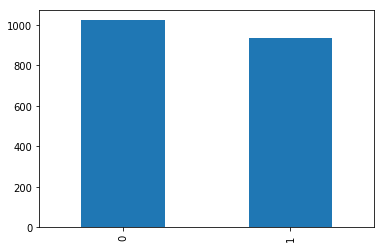

In [41]:
treino.Classificação.value_counts().plot.bar()
plt.show()

- Info do teste

In [42]:
display(teste.info())
teste.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 2113 to 1246
Data columns (total 2 columns):
Classificação           653 non-null int64
Descricao Atualizada    653 non-null object
dtypes: int64(1), object(1)
memory usage: 15.3+ KB


None

,Classificação,Descricao Atualizada
2113,1,numer cord cumpr pres solic melh ferrament tce...
1614,0,tomb moni
284,1,identific numer registr anex numer desp duplic...
2505,1,usu solicit auxili alt er senh
2517,1,consórci públic intermunicip rio grand nort cn...


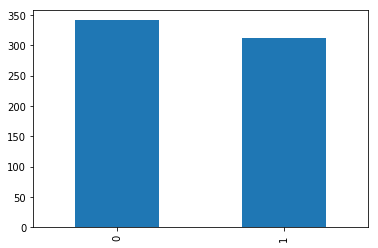

In [43]:
teste.Classificação.value_counts().plot.bar()
plt.show()

### Criando os datasets em CSV

- Arquivo de validação

In [44]:
df_validacao.to_excel('datasets/Chamados_Validação.xlsx', index=False)
#df_validacao.to_csv('datasets/Chamados_Validação.csv', index=False)

- Arquivo de treino

In [45]:
treino.to_excel('datasets/Chamados_Treino.xlsx', index=False)
#treino.to_csv('datasets/Chamados_Treino.csv', index=False)

- Arquivo de teste

In [46]:
teste.to_excel('datasets/Chamados_Teste.xlsx', index=False)
#teste.to_csv('datasets/Chamados_Teste.csv', index=False)